In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Dropout, Flatten, Bidirectional, Concatenate

In [0]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 1000  # Number of samples to train on.

In [0]:
#read from dataset and split into input and targets
df = pd.read_csv("AL_clean_2.csv")
df.head()

,Unnamed: 0,x1,y1,x_count,y_count
0,0,what kind of phones do you guys have,i have a it is pretty great much better than w...,8,8
1,1,i have a it is pretty great much better than w...,does it really charge all the way in min,14,14
2,2,does it really charge all the way in min,pretty fast i have never it but it is under ha...,9,9
3,3,what kind of phones do you guys have,samsung galaxy j it is my first cell phone and...,8,8
4,4,samsung galaxy j it is my first cell phone and...,what do you think of it anything you do not like,16,16


In [0]:
# print(len(df))
# list0 = df["0"].tolist()[:num_samples]
# list1 = df["1"].tolist()[:num_samples]
# list2 = df["2"].tolist()[:num_samples]
# print(len(list0))
# print(len(list1))
# print(len(list2))

In [0]:
print(len(df))
list0 = df["x1"].tolist()[:num_samples]
list1 = df["y1"].tolist()[:num_samples]

print(len(list0))
print(len(list1))


56297
1000
1000


In [0]:
input_texts=[]
target_texts=[]
#match 0 and 1
for i in range(0,num_samples):
    input_texts.append(str(list0[i]).split())
    target_texts.append(['\t'] + str(list1[i]).split() + ['\n'])

# #match 1 and 2
# for i in range(0,num_samples):
#     input_texts.append(list1[i].split())
#     target_texts.append(['\t'] + list2[i].split() + ['\n'])

# #match 0 and 2
# for i in range(0,num_samples):
#     input_texts.append(list0[i].split())
#     target_texts.append(['\t'] + list2[i].split() + ['\n'])
    

In [0]:
#words in input
input_words = set()
for sentence in (input_texts):
    for word in sentence:
        if word not in input_words:
            input_words.add(word)
            
#words in target           
target_words= set()
for sentence in (target_texts):
    for word in sentence:
        if word not in target_words:
            target_words.add(word)

target_words.add("\t")
target_words.add("\n")

In [0]:
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens=len(target_words)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 1000
Number of unique input tokens: 1382
Number of unique output tokens: 1539
Max sequence length for inputs: 25
Max sequence length for outputs: 24


In [0]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

In [0]:
# #one hot vectorization of input and target sentences - 3D array
# encoder_input_data = np.zeros(
#     (len(input_texts), max_encoder_seq_length, num_encoder_tokens), #number of input-ouput pairs, longest input, number of possible input words
#     dtype='float32')
# decoder_input_data = np.zeros(
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens), #number of input-output pairs, longest output, number of possible output words
#     dtype='float32')
# decoder_target_data = np.zeros( #ahead by one time step i.e decorder_target_data @t = decoder_input_data @ t+1. #we want to predict this 
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens), 
#     dtype='float32')

In [0]:
#one hot vectorization of input and target sentences - 3D array
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), #number of input-ouput pairs, longest input
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), #number of input-output pairs, longest output
    dtype='float32')
decoder_target_data = np.zeros( #ahead by one time step i.e decorder_target_data @t = decoder_input_data @ t+1. #we want to predict this 
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), 
    dtype='float32')

In [0]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)): #assign each input/output pair a number 
    for t, word in enumerate(input_text):  #assign each input sentence to a number 
        encoder_input_data[i, t] = input_token_index[word] #@pair i, word t, and where the word is located in the input_token_index
    for t, word in enumerate(target_text): #assign each output sentence to a number 
        decoder_input_data[i, t] = target_token_index[word] #@ pair i, word t, and where the word is located in target_token_index
        if t > 0:  #subtract one time step from input data to get target data 
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [0]:
# Define an input sequence and process it.
dropout_rate  = 0.2

#input 
encoder_inputs = Input(shape=(None, ))

#hidden layers
encoder_embedding = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_dropout   = (TimeDistributed(Dropout(rate = dropout_rate)))(encoder_embedding)

#output layers
encoder_LSTM = Bidirectional(LSTM(latent_dim, return_state=True, dropout=dropout_rate), merge_mode='concat')
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_LSTM(encoder_dropout)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# We discard `encoder_outputs` and only keep the states. 
# encoder_states = [forward_h, forward_c, backward_h, backward_c ]
encoder_states = [state_h, state_c]

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,  ))

#hidden layers
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)(decoder_inputs)
decoder_dropout = (TimeDistributed(Dropout(rate = dropout_rate)))(decoder_embedding)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
# decoder_LSTM_layer = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout = dropout_rate))
# decoder_LSTM,_ , _ , _, _= decoder_LSTM_layer(decoder_dropout, initial_state=encoder_states)

decoder_LSTM_layer = LSTM(latent_dim, return_sequences=True, return_state=True, dropout = dropout_rate)
decoder_LSTM,_ , _ = decoder_LSTM_layer(decoder_dropout, initial_state=encoder_states)

#output
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_LSTM)

ValueError: ignored

In [0]:
from tensorflow.python import keras
print(keras.__version__)

2.3.0-tf


In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 256)    353792      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 256)    393984      input_7[0][0]                    
____________________________________________________________________________________________

In [0]:
history=model.fit(
        [encoder_input_data, decoder_input_data], 
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        # verbose=0,
        validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 9s 11ms/step - loss: 2.3412 - accuracy: 0.1113 - val_loss: 1.7236 - val_accuracy: 0.1346
Epoch 2/50
800/800 [==============================] - 6s 8ms/step - loss: 2.0137 - accuracy: 0.1349 - val_loss: 1.6899 - val_accuracy: 0.1447
Epoch 3/50
800/800 [==============================] - 6s 8ms/step - loss: 1.9380 - accuracy: 0.1423 - val_loss: 1.6822 - val_accuracy: 0.1491
Epoch 4/50
800/800 [==============================] - 6s 8ms/step - loss: 1.8804 - accuracy: 0.1504 - val_loss: 1.6512 - val_accuracy: 0.1579
Epoch 5/50
800/800 [==============================] - 6s 8ms/step - loss: 1.8071 - accuracy: 0.1732 - val_loss: 1.6577 - val_accuracy: 0.1742
Epoch 6/50
800/800 [==============================] - 6s 8ms/step - loss: 1.7237 - accuracy: 0.1928 - val_loss: 1.6279 - val_accuracy: 0.1950
Epoch 7/50
800/800 [==============================] - 6s 8ms/step - loss: 1.6287 - accuracy: 0.2217 -

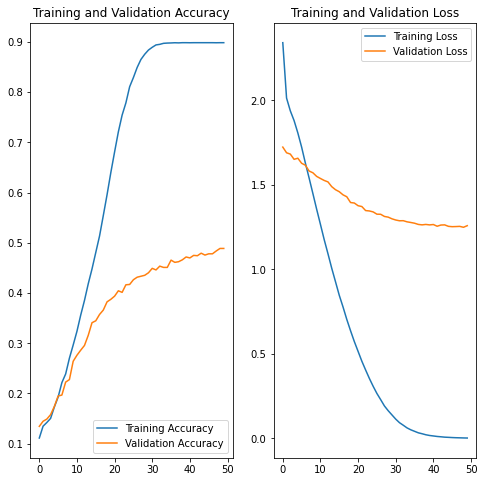

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# Save model
model.save('s2s.h5')

In [92]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c, decoder_state_input_h2, decoder_state_input_c2]

decoder_outputs, forward_h, forward_c, backward_h, backward_c= decoder_LSTM_layer(decoder_dropout, initial_state=decoder_states_inputs)

decoder_states = [forward_h, forward_c, backward_h, backward_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)



ValueError: ignored

In [0]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] =  target_token_index['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # print (decoded_sentence)
        output_tokens, h, c, h2, c2 = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c, h2, c2]

    return decoded_sentence


In [0]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['what', 'kind', 'of', 'phones', 'do', 'you', 'guys', 'have']
Decoded sentence:  	 	 	 	 	 	 	 	 	 	 	 	 	
	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['i', 'have', 'a', 'it', 'is', 'pretty', 'great', 'much', 'better', 'than', 'what', 'i', 'had', 'before']
Decoded sentence:  	 	 	 	 	 	 	 	 	 	 	 	 	
	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['does', 'it', 'really', 'charge', 'all', 'the', 'way', 'in', 'min']
Decoded sentence:  	 	 	 	 	 	 	 	 	 	 	 	 	
	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['what', 'kind', 'of', 'phones', 'do', 'you', 'guys', 'have']
Decoded sentence:  	 	 	 	 	 	 	 	 	 	 	 	 	
	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['samsung', 'galaxy', 'j', 'it', 'is', 'my', 'first', 'cell', 'phone', 'and', 'i', 'have', 'had', 'it', 'for', 'months']
Decoded sentence:  	 	 	 	 	 	 	 	 	 	 	 	 	
	
	
	
	
	
	
	
	
	
	
	
	
	
-
Input sentence: ['what', 'do', 'you', 'think', 'of', 'it', 'anything', 'you', 'do', 'not', 'like']
Decoded 